# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:43<00:00, 2022.20it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [24]:
final['Cleaned_Text']=preprocessed_reviews
print(final.shape)

(87773, 11)


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final, final['Score'], test_size=0.25, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25)


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)


count_vect = CountVectorizer(min_df = 10) #in scikit-learn
final_X_train = count_vect.fit_transform(X_train['Cleaned_Text'].values)
final_X_test =  count_vect.transform(X_test['Cleaned_Text'].values)
final_X_cv = count_vect.transform(X_cv['Cleaned_Text'].values)

(49371, 11) (49371,)
(16458, 11) (16458,)
(21944, 11) (21944,)


In [26]:
from sklearn import preprocessing
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_X_train = preprocessing.normalize(final_X_train)
final_X_test = preprocessing.normalize(final_X_test)
final_X_cv = preprocessing.normalize(final_X_cv) 
print("the type of count vectorizer ",type(final_X_train))
print("the shape of out text BOW vectorizer ",final_X_train.get_shape())
print("the number of unique words ", final_X_train.get_shape()[1])

some feature names  ['aa', 'aafco', 'abdominal', 'ability', 'able', 'abroad', 'absence', 'absent', 'absolute', 'absolutely']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49371, 8726)
the number of unique words  8726


In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr = LogisticRegression(random_state=0)
clf = GridSearchCV(lr,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf.fit(final_X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 5


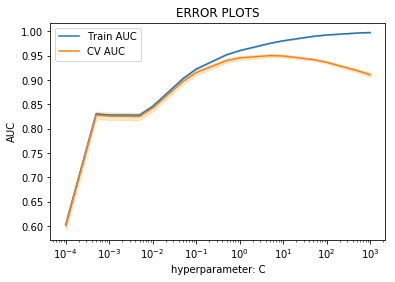

In [28]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Using L1 Penalty

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr1 = LogisticRegression(random_state=0, penalty='l1')
clf1 = GridSearchCV(lr1,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf1.fit(final_X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 5


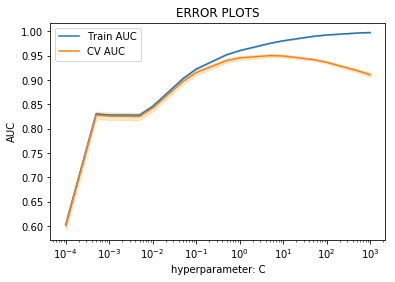

In [30]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [31]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Percentage of misclassified points ", (len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in Recall matrix",A.sum(axis=1))

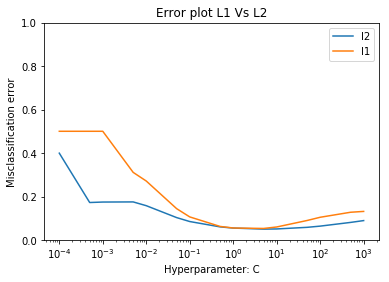

In [32]:
plt.title('Error plot L1 Vs L2')
plt.ylim(0,1)
plt.xlabel('Hyperparameter: C')
plt.ylabel('Misclassification error')
plt.semilogx(param_grid['C'], 1-clf.cv_results_['mean_test_score'], label='l2')
plt.semilogx(param_grid['C'], 1-clf1.cv_results_['mean_test_score'], label='l1')
plt.legend(loc='best')
plt.show()

In [33]:
lr = LogisticRegression(C=5).fit(final_X_train, y_train)
coefs = lr.coef_[0]
temp = pd.DataFrame({'Features':count_vect.get_feature_names(), 'co-efficients':coefs})
sorted_temp=temp.sort_values('co-efficients', axis=0, ascending=True, inplace=False, kind='quicksort')
print("Top 10 negative important feaures")
print(sorted_temp[:10])
print("\nTop 10 positive important features")
print(sorted_temp[:-10:-1])

Top 10 negative important feaures
            Features  co-efficients
8626           worst     -12.092927
2182   disappointing     -10.266663
7783        terrible      -9.381186
468            awful      -8.637097
2183  disappointment      -8.438176
3682        horrible      -7.813972
8460            weak      -7.660853
6462             rip      -7.510902
2212      disgusting      -7.208981
2181    disappointed      -7.187234

Top 10 positive important features
       Features  co-efficients
5527    perfect       9.147678
2006  delicious       9.109619
8595  wonderful       7.938234
467     awesome       7.910853
225     amazing       7.837323
8699      yummy       7.749330
2651  excellent       7.520565
640        best       7.070382
3671     hooked       6.947673


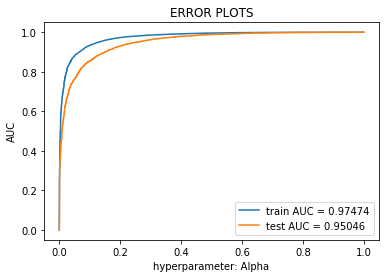

In [34]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(final_X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(final_X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC = %0.5f" %(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = %0.5f" %(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Percentage of misclassified points  5.8171801259848905
-------------------------------------------------- Confusion matrix --------------------------------------------------


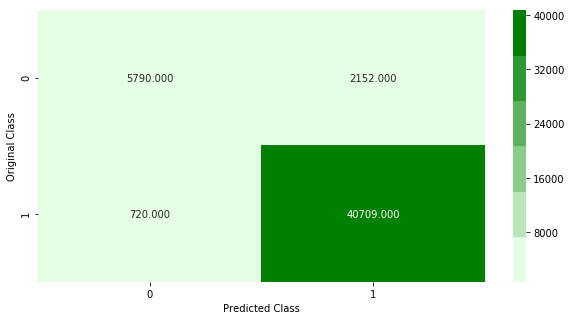

-------------------------------------------------- Precision matrix --------------------------------------------------


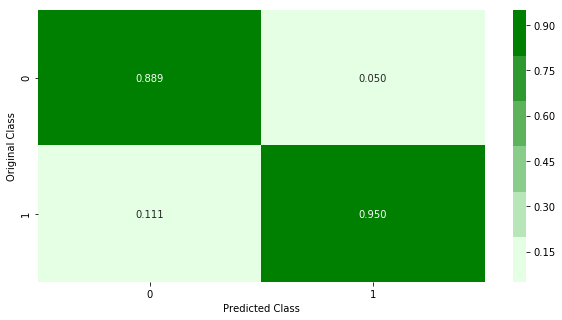

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


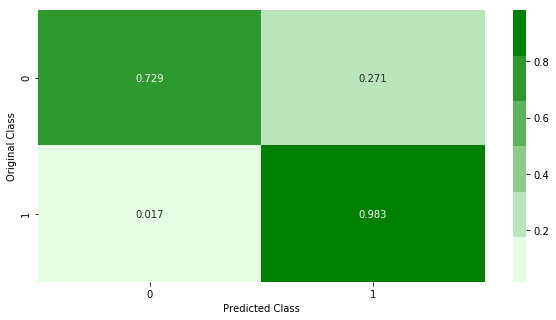

Sum of rows in Recall matrix [1. 1.]


In [35]:
plot_confusion_matrix(y_train, lr.predict(final_X_train))

Percentage of misclassified points  7.979402114473204
-------------------------------------------------- Confusion matrix --------------------------------------------------


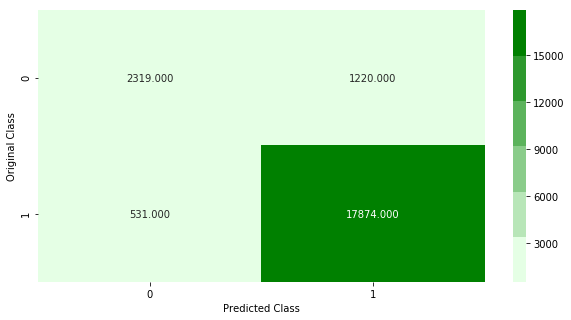

-------------------------------------------------- Precision matrix --------------------------------------------------


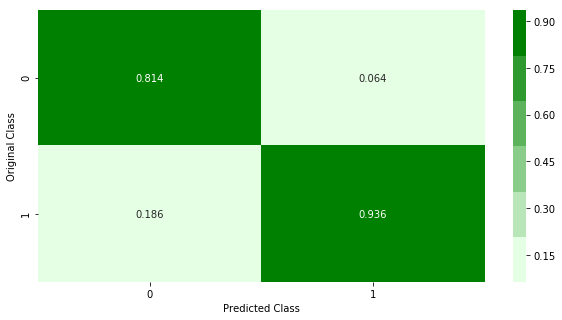

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


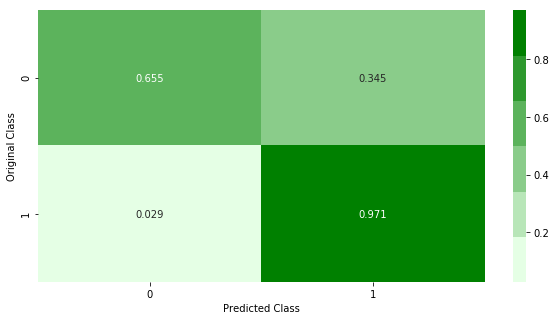

Sum of rows in Recall matrix [1. 1.]


In [36]:
plot_confusion_matrix(y_test, lr.predict(final_X_test))

#### Observation:
1. Used 100k datapoints in building this model.
2. with best C of 5, the model has an roc_auc score of ~97% and ~94% using train and test data respectively which gives confidence that the model is neither overfitting nor underfitting.
3. By looking at the above observations, the model is performing good for positive data points but OK on predicting the negative reviews. May be if we can change the BOW using ngrams, the model may perform better.
4. By looking at the top 10 postitive and negative features, the BoW with unigram performed well in predicting the reviews.

### Pertubation Test

In [37]:
from scipy.sparse import find

clf_original = LogisticRegression(C= 5, penalty= 'l2')
clf_original.fit(final_X_train,y_train)
y_pred = clf_original.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf_original.coef_))

Accuracy on test set: 92.021%
Non Zero weights: 8726


In [38]:
weights1 = find(clf_original.coef_[0])[2]
print(weights1[:50])

[-4.25077344e-01  2.50431408e-01 -1.11286144e-01  4.17845358e-01
  1.69119031e+00  7.41630831e-02  5.95716971e-01  8.14787537e-02
  5.58433749e-01  8.98603056e-01 -1.24717350e-01 -3.62826243e-01
  7.96960818e-01 -6.33937719e-03 -1.11373650e-01  1.87643937e-01
 -7.59154861e-03  6.67296708e-01  1.76952002e-01 -8.63783724e-01
 -2.13229860e+00 -1.18717482e-01  7.05700241e-01  3.51303023e-01
  3.69794302e-01 -5.91181225e-01  1.73532604e-01  2.95081898e-01
  2.68550979e-01  3.67378550e-01 -6.76332035e-02 -3.36317470e-01
 -2.10413016e-01  5.25628505e-04 -7.57207742e-01  1.51548689e+00
 -5.09303762e-01  1.13507476e+00  6.69098874e-01  7.58037718e-02
 -1.48662493e-01  4.14503279e-01 -1.06460952e+00 -1.29022725e+00
 -1.34799384e+00  8.27506683e-01  1.24397165e+00  4.94589785e-01
 -2.45804290e-01 -8.92922038e-01]


In [39]:
X_tr = final_X_train
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_tr)[0].size))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_tr)

#data points before adding noise
print(X_tr[a,b])

#Introducing random noise to non-zero datapoints
X_tr[a,b] = epsilon + X_tr[a,b]
print(X_tr[a,b])

[[0.14586499 0.24253563 0.12403473 ... 0.2236068  0.22941573 0.07198158]]
[[0.14591491 0.24256332 0.12407559 ... 0.22355282 0.22937636 0.07195499]]


In [40]:
# Building a model using the training data that has added noise
clf_noise = LogisticRegression(C= 5, penalty= 'l2')
clf_noise.fit(X_tr,y_train)
y_pred = clf_noise.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf_noise.coef_))

Accuracy on test set: 92.021%
Non Zero weights: 8726


In [41]:
#Weights after adding random noise
weights2 = find(clf_noise.coef_[0])[2]
print(weights2[:50])

[-4.25255228e-01  2.50586388e-01 -1.11472023e-01  4.17597939e-01
  1.69121532e+00  7.42742151e-02  5.95824852e-01  8.07907737e-02
  5.58744454e-01  8.98593193e-01 -1.24600641e-01 -3.63323704e-01
  7.97227442e-01 -6.15428678e-03 -1.11391146e-01  1.87622824e-01
 -7.78288164e-03  6.66985456e-01  1.76675063e-01 -8.64127805e-01
 -2.13217881e+00 -1.19496513e-01  7.05109944e-01  3.51135422e-01
  3.69827146e-01 -5.91167382e-01  1.73481783e-01  2.95398635e-01
  2.68487609e-01  3.67461233e-01 -6.74445628e-02 -3.36522236e-01
 -2.11093279e-01  3.30907302e-04 -7.57342252e-01  1.51530897e+00
 -5.09121857e-01  1.13505884e+00  6.68272308e-01  7.58356331e-02
 -1.48844050e-01  4.14434104e-01 -1.06425283e+00 -1.28964151e+00
 -1.34770925e+00  8.27248936e-01  1.24383148e+00  4.94387075e-01
 -2.45761107e-01 -8.92368674e-01]


In [42]:
print(weights2.size)

8726


In [43]:
#Calculating the percentage error for the weights
weights_diff = (abs(weights1 - weights2)/weights1) * 100
print(weights_diff)

# Packing the origial weight, weight with noise and percentage error w.r.t weight for future use
weights_pack = list(zip(weights1, weights2, weights_diff))
print(weights_pack[:10])

[-0.04184745  0.06188528 -0.16702792 ...  0.03441885  0.06136008
  0.11995719]
[(-0.4250773438651951, -0.42525522787685643, -0.041847445936278364), (0.2504314082564791, 0.2505863884438521, 0.06188528365991136), (-0.1112861440860304, -0.11147202301606465, -0.1670279184896222), (0.41784535768363834, 0.4175979386380202, 0.059213065568021535), (1.691190314750626, 1.6912153244889363, 0.0014788245942627606), (0.07416308306947124, 0.07427421512061687, 0.14984820822716863), (0.5957169709284614, 0.5958248517559301, 0.01810940979246746), (0.08147875368261341, 0.08079077372599126, 0.8443673050057398), (0.5584337485593719, 0.5587444540008253, 0.055638729259279776), (0.8986030559944481, 0.8985931928527291, 0.0010976082991515207)]


In [44]:
# Creating the dictionary with feature name as key and its original weight as value for future use.
coef_dict = {}
for coef, feat in zip(clf_original.coef_[0,:],count_vect.get_feature_names()):
    coef_dict[feat] = coef
print(coef_dict)

{'aa': -0.4250773438651951, 'aafco': 0.2504314082564791, 'abdominal': -0.1112861440860304, 'ability': 0.41784535768363834, 'able': 1.691190314750626, 'abroad': 0.07416308306947124, 'absence': 0.5957169709284614, 'absent': 0.08147875368261341, 'absolute': 0.5584337485593719, 'absolutely': 0.8986030559944481, 'absolutly': -0.12471735047009441, 'absorb': -0.36282624286290155, 'absorbed': 0.7969608176039689, 'absorbs': -0.006339377193231299, 'abundance': -0.11137364999748331, 'abundant': 0.18764393657119915, 'acai': -0.0075915486080138615, 'acana': 0.6672967082252168, 'accent': 0.17695200174300302, 'accept': -0.8637837242882792, 'acceptable': -2.132298603336287, 'accepted': -0.11871748231587774, 'access': 0.7057002411738849, 'accessible': 0.3513030225220811, 'accident': 0.3697943016263526, 'accidentally': -0.5911812245516058, 'accidents': 0.17353260423398123, 'accompanied': 0.29508189823821945, 'accompaniment': 0.2685509785513067, 'accompany': 0.36737854983714646, 'accomplished': -0.067633

In [45]:
for i in range(0,100,10):
    var = weights_diff
    var = np.sort(var)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])
print(var[:5])

0 percentile value is -121.7175567542305
10 percentile value is -0.12157955032452022
20 percentile value is -0.04990703215676461
30 percentile value is -0.023022938916347043
40 percentile value is -0.007031416116193172
50 percentile value is 0.004129689156438936
60 percentile value is 0.015313313649508114
70 percentile value is 0.029934609212026154
80 percentile value is 0.052375602282462574
90 percentile value is 0.11764151415957198
100 percentile value is  811.8013465364581
[-121.71755675  -30.09287632  -18.08132658  -17.264737    -16.49554082]


In [46]:
for i in range(90,100):
    var = weights_diff
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 0.11764151415957198
91 percentile value is 0.13024889364174455
92 percentile value is 0.14708186168151638
93 percentile value is 0.16944800222508355
94 percentile value is 0.20340439176574648
95 percentile value is 0.24474059225681197
96 percentile value is 0.3075000272889066
97 percentile value is 0.38684466953718777
98 percentile value is 0.567242780356114
99 percentile value is 1.1258000198608775
100 percentile value is  811.8013465364581


In [47]:
# Observed there is a sudden increase in percentage error at 100th percentile so considering the treshold as 10 to 
# see the multicollinearity features

for i,j,k in weights_pack:
    if k > 10:
        print('Feature name is:')
        print([feat for feat,wt in coef_dict.items() if wt == i] )           
        print('percentage error:', k)
        print('*'*50)


Feature name is:
['account']
percentage error: 37.04540390344302
**************************************************
Feature name is:
['emulsifier']
percentage error: 236.99194017803958
**************************************************
Feature name is:
['manufacture']
percentage error: 41.64110701709222
**************************************************
Feature name is:
['posting']
percentage error: 92.23235110649249
**************************************************
Feature name is:
['reorder']
percentage error: 811.8013465364581
**************************************************
Feature name is:
['respectable']
percentage error: 34.05202963242705
**************************************************
Feature name is:
['samples']
percentage error: 56.23418124631352
**************************************************
Feature name is:
['splash']
percentage error: 19.58994969360947
**************************************************
Feature name is:
['treating']
percentage error: 171.806973866

In [48]:
# alternate way to get the weights above the given treshold value, does the same job as the above steps do.
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 10)])

9
[ 37.0454039  236.99194018  41.64110702  92.23235111 811.80134654
  34.05202963  56.23418125  19.58994969 171.80697387]


### checking the sparsity of weight vectors obtained with L1 regularization

In [49]:
from sklearn.metrics import f1_score
clf1 = LogisticRegression(C= 1000, penalty= 'l1')
clf1.fit(final_X_train,y_train)
y_pred = clf1.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf1.coef_))

Accuracy on test set: 85.677%
F1-Score on test set: 0.913
Non Zero weights: 7960


In [50]:
clf1 = LogisticRegression(C= 100, penalty= 'l1')
clf1.fit(final_X_train,y_train)
y_pred = clf1.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf1.coef_))

Accuracy on test set: 88.270%
F1-Score on test set: 0.930
Non Zero weights: 7337


In [51]:
clf1 = LogisticRegression(C= 10, penalty= 'l1')
clf1.fit(final_X_train,y_train)
y_pred = clf1.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf1.coef_))

Accuracy on test set: 91.396%
F1-Score on test set: 0.949
Non Zero weights: 4643


In [52]:
clf1 = LogisticRegression(C= 1, penalty= 'l1')
clf1.fit(final_X_train,y_train)
y_pred = clf1.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf1.coef_))

Accuracy on test set: 91.592%
F1-Score on test set: 0.951
Non Zero weights: 986


In [53]:
clf1 = LogisticRegression(C= 0.1, penalty= 'l1')
clf1.fit(final_X_train,y_train)
y_pred = clf1.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf1.coef_))

Accuracy on test set: 88.202%
F1-Score on test set: 0.933
Non Zero weights: 142


In [54]:
clf1 = LogisticRegression(C= 0.01, penalty= 'l1')
clf1.fit(final_X_train,y_train)
y_pred = clf1.predict(final_X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf1.coef_))

Accuracy on test set: 83.886%
F1-Score on test set: 0.912
Non Zero weights: 7


## [4.3] TF-IDF

In [55]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

tfidf_X_train = tf_idf_vect.fit_transform(X_train['Cleaned_Text'].values)
tfidf_X_test = tf_idf_vect.transform(X_test['Cleaned_Text'].values)
tfidf_X_cv = tf_idf_vect.transform(X_cv['Cleaned_Text'].values)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_cv = preprocessing.normalize(tfidf_X_cv)
print("the type of count vectorizer ",type(tfidf_X_train))
print("the shape of out text TFIDF vectorizer ",tfidf_X_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_X_train.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (49371, 29312)
the number of unique words including both unigrams and bigrams  29312


In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr = LogisticRegression(random_state=0)
clf = GridSearchCV(lr,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf.fit(tfidf_X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 5


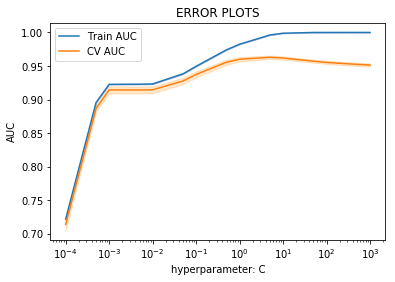

In [57]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Using l1 penalty

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr1 = LogisticRegression(random_state=0, penalty='l1')
clf1 = GridSearchCV(lr1,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf1.fit(tfidf_X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 5


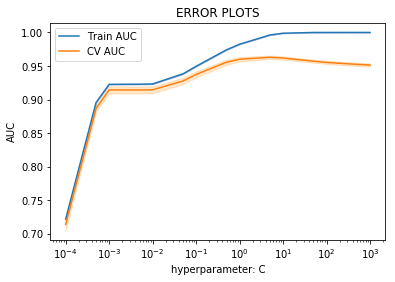

In [59]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

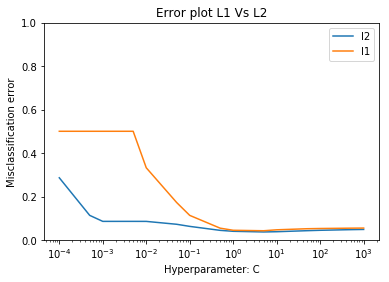

In [60]:
plt.title('Error plot L1 Vs L2')
plt.ylim(0,1)
plt.xlabel('Hyperparameter: C')
plt.ylabel('Misclassification error')
plt.semilogx(param_grid['C'], 1-clf.cv_results_['mean_test_score'], label='l2')
plt.semilogx(param_grid['C'], 1-clf1.cv_results_['mean_test_score'], label='l1')
plt.legend(loc='best')
plt.show()

In [61]:
lr = LogisticRegression(C=5).fit(tfidf_X_train, y_train)
coefs = lr.coef_[0]
temp = pd.DataFrame({'Features':tf_idf_vect.get_feature_names(), 'co-efficients':coefs})
sorted_temp=temp.sort_values('co-efficients', axis=0, ascending=True, inplace=False, kind='quicksort')
print("Top 10 negative important feaures")
print(sorted_temp[:10])
print("\nTop 10 positive important features")
print(sorted_temp[:-10:-1])

Top 10 negative important feaures
            Features  co-efficients
28891          worst     -10.674898
17773      not worth     -10.529434
6551    disappointed     -10.474275
17598  not recommend      -9.805731
17386       not good      -9.430886
25947       terrible      -8.939261
6566   disappointing      -8.934947
1430           awful      -8.284810
17135            not      -8.232536
28283           weak      -7.933608

Top 10 positive important features
               Features  co-efficients
11248             great      14.416371
6156          delicious      12.215213
1997               best      10.941609
10755              good      10.683610
19248           perfect      10.511262
17285  not disappointed       9.444209
14939             loves       8.592831
28771         wonderful       8.379739
16817              nice       8.169589


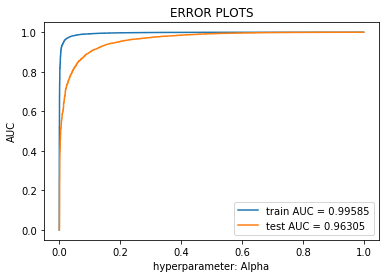

In [62]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(tfidf_X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC = %0.5f" %(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = %0.5f" %(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Percentage of misclassified points  2.635150189382431
-------------------------------------------------- Confusion matrix --------------------------------------------------


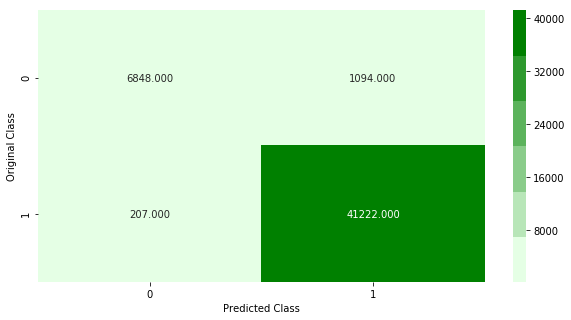

-------------------------------------------------- Precision matrix --------------------------------------------------


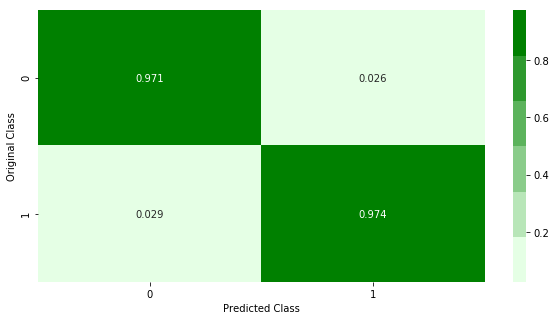

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


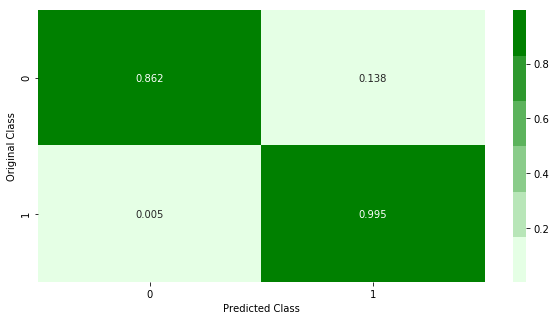

Sum of rows in Recall matrix [1. 1.]


In [63]:
plot_confusion_matrix(y_train, lr.predict(tfidf_X_train))

Percentage of misclassified points  7.168246445497631
-------------------------------------------------- Confusion matrix --------------------------------------------------


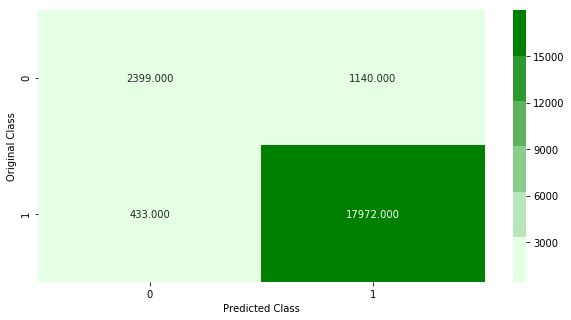

-------------------------------------------------- Precision matrix --------------------------------------------------


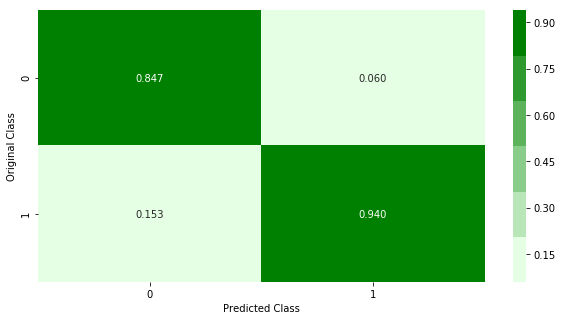

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


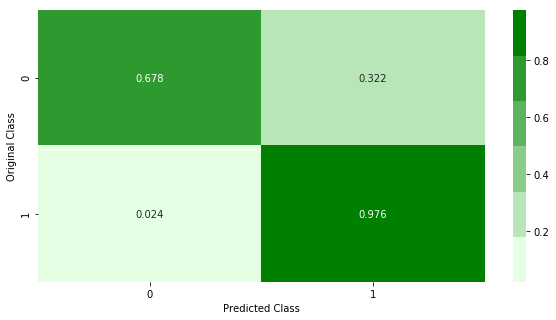

Sum of rows in Recall matrix [1. 1.]


In [64]:
plot_confusion_matrix(y_test, lr.predict(tfidf_X_test))

#### Observation:
1. Used 100k datapoints in building this model.
2. with best C of 5, the model has an roc_auc score of ~99% and ~96% using train and test data respectively which gives confidence that the model is neither overfitting nor underfitting.
3. By looking at the above observations, the model is performing good for positive data points but OK on predicting the negative reviews.
4. After considering the confusion matricex of both BoW(uni-gram) and tf-idf, tf-idf slightly performed better than BoW (uni-gram).

## [4.4] Word2Vec

In [65]:
# Train your own Word2Vec model using your own text corpus

list_of_sentance=[]
for sentance in X_train['Cleaned_Text']:
    list_of_sentance.append(sentance.split())

print(list_of_sentance[0:5])

[['course', 'cannot', 'replace', 'real', 'pasta', 'no', 'carb', 'low', 'carb', 'diet', 'wonderful', 'option', 'cooked', 'one', 'bag', 'tomato', 'based', 'pasta', 'sauce', 'verdict', 'happy', 'satisfied', 'not', 'issue', 'eating', 'real', 'pasta', 'not', 'see', 'would', 'settle', 'nothing', 'like', 'real', 'deal', 'need', 'cut', 'back', 'urge', 'eat', 'pasta', 'great', 'option', 'stocking'], ['bought', 'keurig', 'machine', 'months', 'ago', 'like', 'everyone', 'else', 'tried', 'varieties', 'came', 'said', 'machine', 'ordered', 'varieties', 'try', 'coffee', 'people', 'bold', 'black', 'tiger', 'dark', 'roast', 'simply', 'best', 'good', 'strong', 'coffee', 'flavor', 'no', 'bitterness', 'try', 'like'], ['love', 'love', 'love', 'torani', 'sugar', 'free', 'syrups', 'little', 'barista', 'kitchen', 'easy', 'access', 'pumps', 'use', 'everything', 'morning', 'coffee', 'girls', 'night', 'mixed', 'vodka', 'drinks'], ['enjoy', 'dried', 'fruit', 'not', 'hesitate', 'awesome', 'product', 'fast', 'shippi

In [66]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(X_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('terrific', 0.7989331483840942), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748856544494629), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841565370559692), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146092414855957), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180715560913), ('best', 0.5835110545158386), ('bleakest', 0.5718506574630737), ('strongest', 0.567145586013794), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]
number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year',

## Converting text into vectors using Avg W2V, TFIDF-W2V

#### Avg W2v

In [67]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████| 49371/49371 [1:11:55<00:00, 11.44it/s]


49371
300


In [68]:
list_of_sentance_cv=[]
for sentance in X_cv['Cleaned_Text']:
    list_of_sentance_cv.append(sentance.split())

In [69]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 16458/16458 [21:24<00:00, 12.81it/s]


(16458, 300)
[ 0.02065398  0.01351607  0.04778812  0.11955703 -0.0308862   0.01455809
  0.05630654 -0.08649806  0.06635967  0.07836272 -0.04811658 -0.12024327
  0.00230247  0.03699052 -0.11001105  0.10970909  0.06488358  0.11506312
  0.00312263 -0.06507793 -0.01736691  0.02784026 -0.0130294  -0.01195486
 -0.00104141 -0.02820334 -0.08138877  0.08662595  0.01537604  0.01400335
 -0.01280052 -0.01292038 -0.02983053  0.0492618   0.00118416 -0.00547991
  0.05869943 -0.00466718 -0.01148063  0.00258074  0.06484503 -0.04944892
  0.0399957  -0.00362195 -0.02311526 -0.09063154 -0.01631325 -0.00180244
 -0.01557039  0.04416777 -0.0401527   0.10038998 -0.04970791  0.0016881
  0.00230327  0.04333335  0.00467883 -0.0860403   0.07290168 -0.08078846
  0.0126917   0.05937596 -0.05761398 -0.08049573 -0.01561898 -0.0263965
 -0.04489778  0.07528205 -0.03307784  0.06279634  0.0649143   0.00748902
  0.08471261  0.04238651 -0.13969421 -0.05647469  0.0460454   0.06241648
  0.08163532  0.0829532   0.01207532 -0.

In [70]:
list_of_sentance_test=[]
for sentance in X_test['Cleaned_Text']:
    list_of_sentance_test.append(sentance.split())

In [71]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 21944/21944 [31:43<00:00, 11.53it/s]


(21944, 300)
[ 0.03007923  0.05672663 -0.04692078  0.16163497 -0.0667572   0.033389
  0.04692633 -0.06505758  0.06034574  0.08202015 -0.00775146 -0.16386968
 -0.03167794  0.02595104 -0.13936268  0.03172372  0.10899769  0.09302382
 -0.04120705 -0.00965985  0.0274894  -0.00387296  0.05035955 -0.00838956
  0.01827448  0.02613518 -0.07136119  0.11430775  0.0730896  -0.03493292
 -0.05447388 -0.05354448  0.02247516 -0.01906239  0.00592318  0.03359257
  0.07587849 -0.00325914 -0.016879    0.09842751  0.05235379 -0.06894753
  0.12389859 -0.01333341 -0.04961326 -0.07494701 -0.00048828  0.05500377
 -0.02100719  0.01551958 -0.05273992 -0.00599254 -0.02800265 -0.03553078
  0.00430042 -0.04312411 -0.02036355 -0.07438521  0.10249953 -0.09202368
  0.01695043  0.06445867 -0.11678938 -0.00902211  0.0279378  -0.03973944
 -0.08695845  0.1064571  -0.09256259 -0.02485379  0.07775463  0.01955344
  0.0368694   0.03510284 -0.23859197 -0.03227373  0.00966852  0.05815402
 -0.00523931  0.05018338  0.03416582 -0.

In [72]:
sent_vectors = preprocessing.normalize(sent_vectors)
sent_vectors_test = preprocessing.normalize(sent_vectors_test)
sent_vectors_cv = preprocessing.normalize(sent_vectors_cv)

In [73]:
train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr = LogisticRegression(random_state=0)
clf = GridSearchCV(lr,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf.fit(sent_vectors, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 5


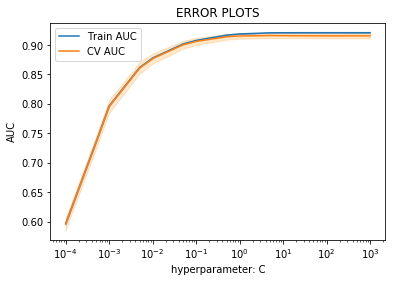

In [74]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Using L1 Penalty

In [75]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr1 = LogisticRegression(random_state=0, penalty='l1')
clf1 = GridSearchCV(lr1,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf1.fit(sent_vectors, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 22.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 5


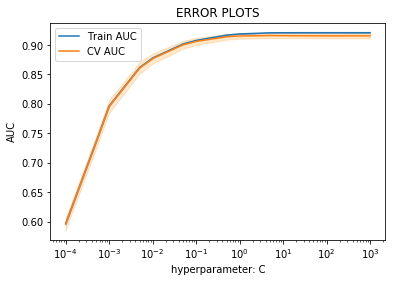

In [76]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

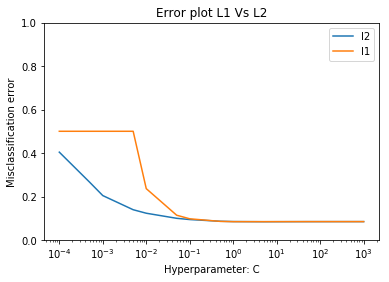

In [77]:
plt.title('Error plot L1 Vs L2')
plt.ylim(0,1)
plt.xlabel('Hyperparameter: C')
plt.ylabel('Misclassification error')
plt.semilogx(param_grid['C'], 1-clf.cv_results_['mean_test_score'], label='l2')
plt.semilogx(param_grid['C'], 1-clf1.cv_results_['mean_test_score'], label='l1')
plt.legend(loc='best')
plt.show()

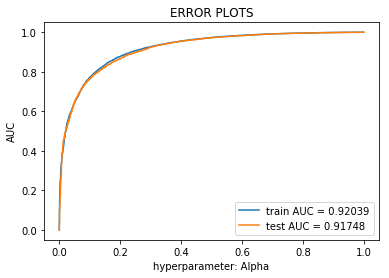

In [79]:
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C=5).fit(sent_vectors, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC = %0.5f" %(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = %0.5f" %(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Percentage of misclassified points  10.206396467561929
-------------------------------------------------- Confusion matrix --------------------------------------------------


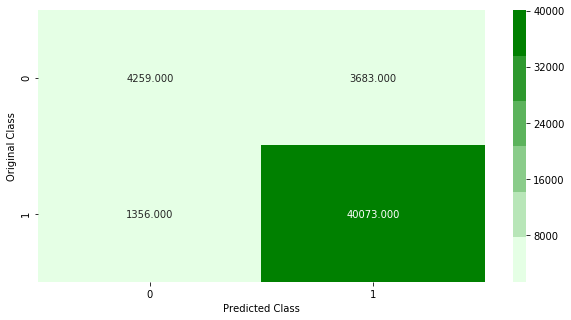

-------------------------------------------------- Precision matrix --------------------------------------------------


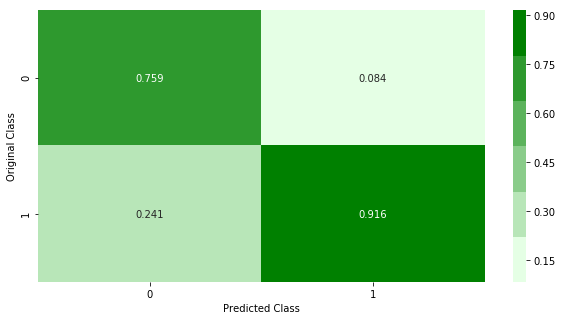

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


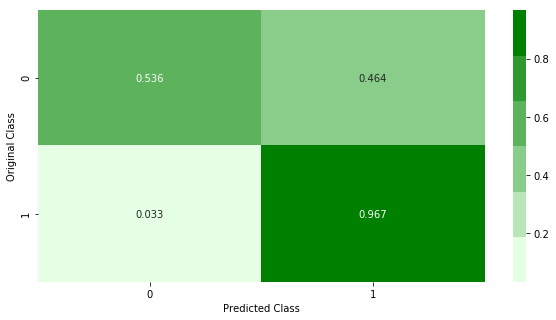

Sum of rows in Recall matrix [1. 1.]


In [80]:
plot_confusion_matrix(y_train, lr.predict(sent_vectors))

Percentage of misclassified points  10.312613926358003
-------------------------------------------------- Confusion matrix --------------------------------------------------


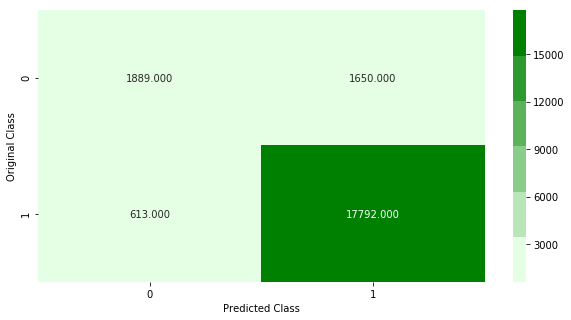

-------------------------------------------------- Precision matrix --------------------------------------------------


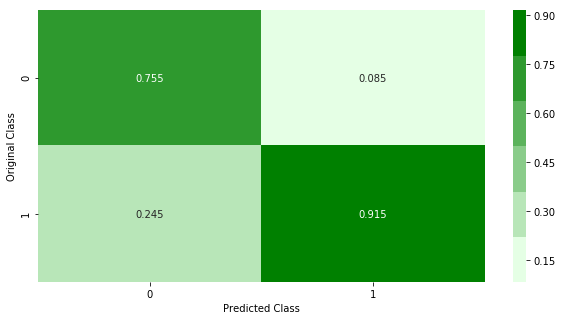

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


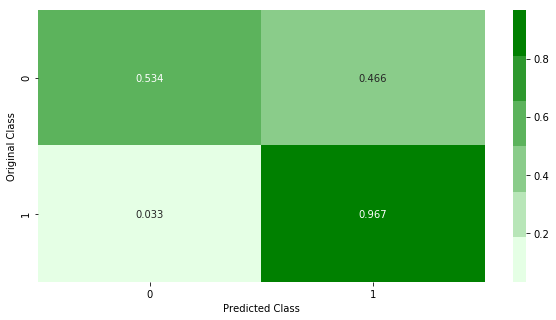

Sum of rows in Recall matrix [1. 1.]


In [81]:
plot_confusion_matrix(y_test, lr.predict(sent_vectors_test))

#### Observation:
1. Used 100k datapoints in building this model.
2. with best C of 5, the model has an roc_auc score of ~92% and ~91% using train and test data respectively which gives confidence that the model is neither overfitting nor underfitting.
3. By looking at the above observations, the model is performing good for positive data points but OK on predicting the negative reviews.

#### [4.4.1.2] TFIDF weighted W2v

In [82]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['Cleaned_Text'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [83]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 49371/49371 [1:35:13<00:00,  8.64it/s]


In [84]:
model.transform(X_test['Cleaned_Text'])
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [86]:
# TF-IDF weighted Word2Vec
tfidf_feat_test = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_test:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 21944/21944 [45:52<00:00,  7.74it/s]


In [87]:
model.transform(X_cv['Cleaned_Text'])
dictionary_cv = dict(zip(model.get_feature_names(), list(model.idf_)))

In [88]:
# TF-IDF weighted Word2Vec
tfidf_feat_cv = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_cv:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 16458/16458 [31:53<00:00,  8.60it/s]


In [89]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
tfidf_sent_vectors_cv = preprocessing.normalize(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test = preprocessing.normalize(tfidf_sent_vectors_test)

In [90]:
train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr = LogisticRegression(random_state=0)
clf = GridSearchCV(lr,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf.fit(tfidf_sent_vectors, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 1


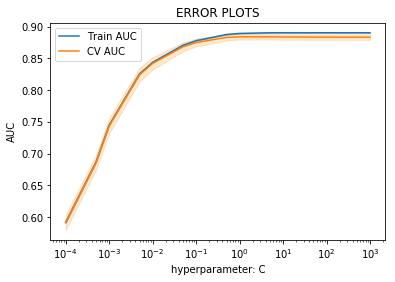

In [91]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

#### Using L1 Penalty

In [92]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]}

lr1 = LogisticRegression(random_state=0, penalty='l1')
clf1 = GridSearchCV(lr1,param_grid,cv=10,verbose=1,scoring='roc_auc', n_jobs=-1)
clf1.fit(tfidf_sent_vectors, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 18.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

Best Alpha value: 1


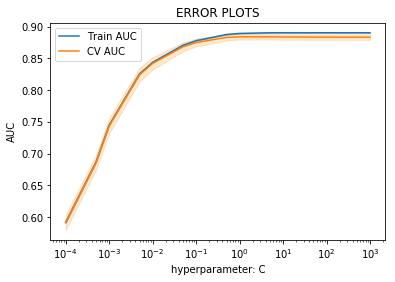

In [93]:
optimal_C = clf.best_params_['C']
print("Best Alpha value:", optimal_C)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.semilogx(param_grid['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(param_grid['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(param_grid['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("hyperparameter: C")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

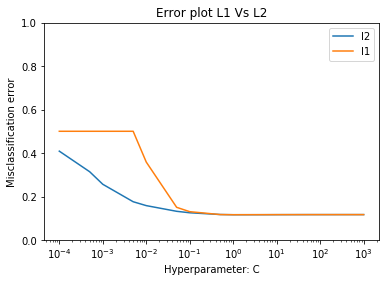

In [94]:
plt.title('Error plot L1 Vs L2')
plt.ylim(0,1)
plt.xlabel('Hyperparameter: C')
plt.ylabel('Misclassification error')
plt.semilogx(param_grid['C'], 1-clf.cv_results_['mean_test_score'], label='l2')
plt.semilogx(param_grid['C'], 1-clf1.cv_results_['mean_test_score'], label='l1')
plt.legend(loc='best')
plt.show()

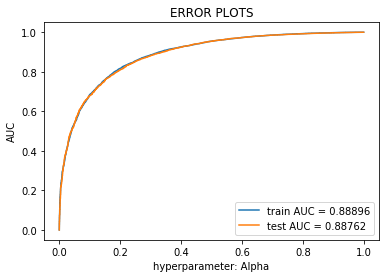

In [96]:
from sklearn.metrics import roc_curve, auc

lr = LogisticRegression(C=1).fit(tfidf_sent_vectors, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC = %0.5f" %(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = %0.5f" %(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter: Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Percentage of misclassified points  11.909825606125054
-------------------------------------------------- Confusion matrix --------------------------------------------------


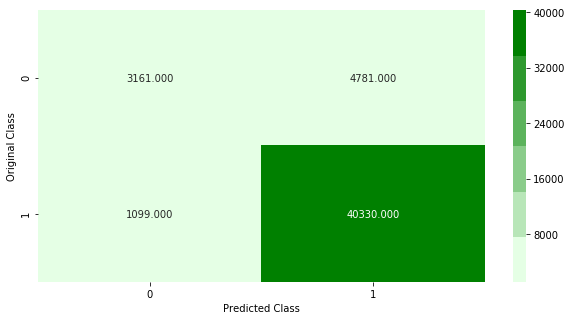

-------------------------------------------------- Precision matrix --------------------------------------------------


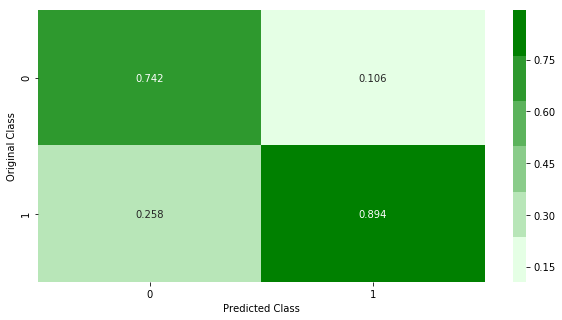

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


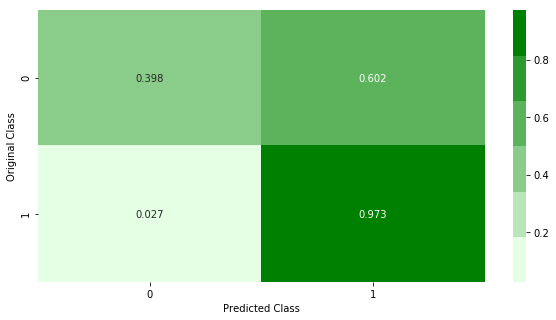

Sum of rows in Recall matrix [1. 1.]


In [97]:
plot_confusion_matrix(y_train, lr.predict(tfidf_sent_vectors))

Percentage of misclassified points  11.930368209989064
-------------------------------------------------- Confusion matrix --------------------------------------------------


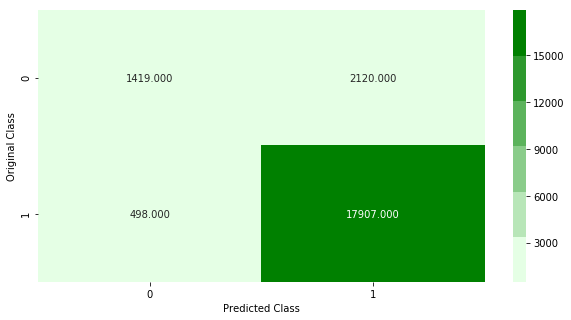

-------------------------------------------------- Precision matrix --------------------------------------------------


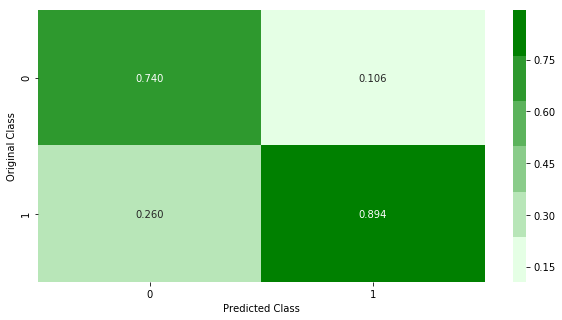

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


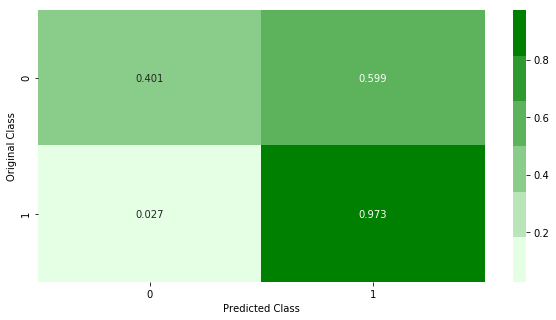

Sum of rows in Recall matrix [1. 1.]


In [98]:
plot_confusion_matrix(y_test, lr.predict(tfidf_sent_vectors_test))

#### Observation:
1. Used 100k datapoints in building this model.
2. with best C of 1, the model has an roc_auc score of ~88% and ~88% using train and test data respectively which gives confidence that the model is neither overfitting nor underfitting.
3. By looking at the above observations, the model is performing good for positive data points but OK on predicting the negative reviews. May be if we can change the BOW using ngrams, the model may perform better.
4. After performing the logistic regression on all the 4 sets, tfidf performed better in this case.

# [6] Conclusions

In [99]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['Tokenizer', 'Train AUC score', 'Test AUC score']
ptable.add_row(["BoW (uni-gram)","0.97","0.95"])
ptable.add_row(["tfidf","0.99","0.96"])
ptable.add_row(["Avg W2V","0.92","0.91"])
ptable.add_row(["tfidfW2V","0.88","0.88"])

print(ptable)

+----------------+-----------------+----------------+
|   Tokenizer    | Train AUC score | Test AUC score |
+----------------+-----------------+----------------+
| BoW (uni-gram) |       0.97      |      0.95      |
|     tfidf      |       0.99      |      0.96      |
|    Avg W2V     |       0.92      |      0.91      |
|    tfidfW2V    |       0.88      |      0.88      |
+----------------+-----------------+----------------+
